In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from joblib import dump, load
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
param_sets = [
    {'var_smoothing': 1e-9},   
    {'var_smoothing': 1e-5},  
    {'var_smoothing': 1e-1}   
]

# Đọc dữ liệu train
train_data = pd.read_csv('R2G_output/undersampled_train.csv')
X_train = train_data.drop('Label', axis=1)
y_train = train_data['Label']

# Khởi tạo StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá từng bộ tham số
all_cv_metrics = []
for i, params in enumerate(param_sets, 1):
    print(f"Đang đánh giá Param Set {i} (var_smoothing={params['var_smoothing']})...")
    fold_metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = GaussianNB(**params)
        
        # Train và đo thời gian
        start_time = time.time()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        end_time = time.time()
        
        # Tính metrics (không bao gồm model size)
        metrics = [
            accuracy_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            f1_score(y_val, y_pred),
            roc_auc_score(y_val, y_pred),
            end_time - start_time
        ]
        
        # Tính model size riêng
        temp_path = f'temp_model_fold_{i}.joblib'
        dump(model, temp_path)
        model_size = os.path.getsize(temp_path) / 1024
        os.remove(temp_path)
        
        # Thêm model size vào metrics
        metrics.append(model_size)
        fold_metrics.append(metrics)
    
    avg_metrics = np.mean(fold_metrics, axis=0)
    all_cv_metrics.append(avg_metrics)
    print(f"Kết quả: Accuracy={avg_metrics[0]:.4f}, AUC={avg_metrics[4]:.4f}, Time={avg_metrics[5]:.2f}s")

metrics_cv1, metrics_cv2, metrics_cv3 = all_cv_metrics

Đang đánh giá Param Set 1 (var_smoothing=1e-09)...
Kết quả: Accuracy=0.5916, AUC=0.6834, Time=0.77s
Đang đánh giá Param Set 2 (var_smoothing=1e-05)...
Kết quả: Accuracy=0.5920, AUC=0.6842, Time=0.81s
Đang đánh giá Param Set 3 (var_smoothing=0.1)...
Kết quả: Accuracy=0.5700, AUC=0.6725, Time=0.79s


In [3]:
# Đọc dữ liệu test
test_data = pd.read_csv('R2G_output/undersampled_test.csv')
X_test = test_data.drop('Label', axis=1)
y_test = test_data['Label']

# Đánh giá từng bộ tham số
all_test_metrics = []
for i, params in enumerate(param_sets, 1):
    print(f"\nĐang đánh giá Param Set {i} trên test set...")
    model = GaussianNB(**params)
    
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    # Tính metrics
    # Tính metrics
    metrics = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred),
        end_time - start_time
    ]
    
    # Lưu model và tính kích thước
    model_path = f'bayes_model_undersampled{i}.joblib'
    dump(model, model_path)
    model_size = os.path.getsize(model_path) / 1024
    metrics.append(model_size)
    
    all_test_metrics.append(metrics)
    print(f"Param Set {i} - Test Metrics:", [f"{x:.4f}" for x in metrics])

metrics_test1, metrics_test2, metrics_test3 = all_test_metrics


Đang đánh giá Param Set 1 trên test set...
Param Set 1 - Test Metrics: ['0.5911', '0.4472', '0.9608', '0.6104', '0.6835', '1.1773', '1.7568']

Đang đánh giá Param Set 2 trên test set...
Param Set 2 - Test Metrics: ['0.5914', '0.4475', '0.9628', '0.6110', '0.6842', '1.0044', '1.7568']

Đang đánh giá Param Set 3 trên test set...
Param Set 3 - Test Metrics: ['0.5689', '0.4350', '0.9815', '0.6028', '0.6721', '1.0020', '1.7568']


In [4]:
# Tạo báo cáo Excel
report_data = []
for i in range(3):
    report_data.append([
        f"Param Set {i+1} (CV)",
        f"var_smoothing={param_sets[i]['var_smoothing']}",
        all_cv_metrics[i][0] * 100,
        all_cv_metrics[i][1] * 100,
        all_cv_metrics[i][2] * 100,
        all_cv_metrics[i][3] * 100,
        all_cv_metrics[i][4] * 100,
        all_cv_metrics[i][5],
        all_cv_metrics[i][6]
    ])
    report_data.append([
        f"Param Set {i+1} (Test)",
        f"var_smoothing={param_sets[i]['var_smoothing']}",
        all_test_metrics[i][0] * 100,
        all_test_metrics[i][1] * 100,
        all_test_metrics[i][2] * 100,
        all_test_metrics[i][3] * 100,
        all_test_metrics[i][4] * 100,
        all_test_metrics[i][5],
        all_test_metrics[i][6]
    ])

report_df = pd.DataFrame(report_data, 
                        columns=['Model', 'Params', 'Accuracy (%)', 'Precision (%)', 
                                 'Recall (%)', 'F1 (%)', 'AUC (%)', 'Exec Time (s)', 'Model Size (KB)'])
report_df.to_excel('bayes_undersampled_report.xlsx', index=False)
print("\nĐã lưu báo cáo vào 'bayes_undersampled_report.xlsx'")


Đã lưu báo cáo vào 'bayes_undersampled_report.xlsx'


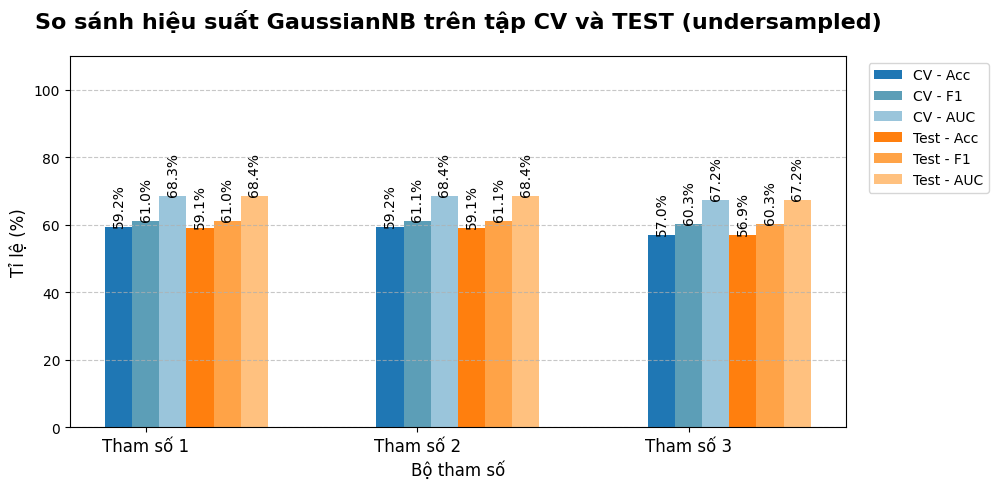

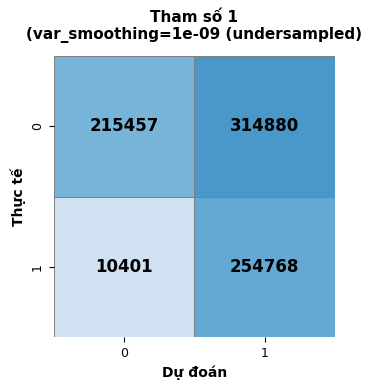

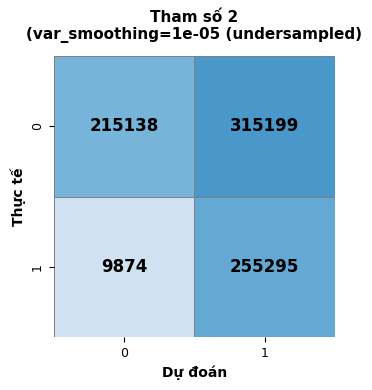

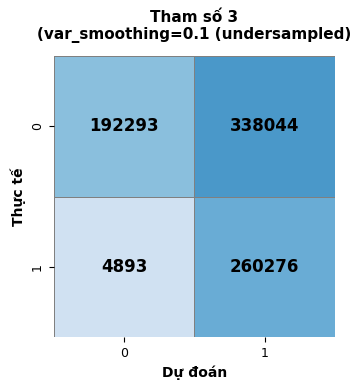

In [5]:
# 1. Vẽ biểu đồ so sánh CV vs Test
labels = ['Acc', 'F1', 'AUC'] * 2  # Nhãn cho 6 cột
colors = ['#1f77b4', '#5c9eb7', '#9ac5db', '#ff7f0e', '#ffa347', '#ffc17f']  # Xanh nhạt dần -> cam nhạt dần

# Tạo mảng giá trị cho từng param set
data = []
for i in range(len(param_sets)):
    # Thêm 3 giá trị CV (acc, f1, auc)
    data.extend([all_cv_metrics[i][0]*100, all_cv_metrics[i][3]*100, all_cv_metrics[i][4]*100])
    # Thêm 3 giá trị Test (acc, f1, auc)
    data.extend([all_test_metrics[i][0]*100, all_test_metrics[i][3]*100, all_test_metrics[i][4]*100])

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
x = np.arange(len(param_sets))  
width = 0.10  

# Vẽ từng cột
bars = []
for i in range(6): 
    bar_pos = x + (i * width) - (1 * width)  
    bars.append(plt.bar(bar_pos, 
                       [data[j*6 + i] for j in range(len(param_sets))], 
                       width, 
                       color=colors[i]))

# Cấu hình trục và nhãn
plt.title('So sánh hiệu suất GaussianNB trên tập CV và TEST (undersampled)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Bộ tham số', fontsize=12)
plt.ylabel('Tỉ lệ (%)', fontsize=12)
plt.xticks(x, [f'Tham số {i+1}' for i in range(len(param_sets))], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm chú thích
legend_labels = ['CV - Acc', 'CV - F1', 'CV - AUC', 'Test - Acc', 'Test - F1', 'Test - AUC']
plt.legend(bars, legend_labels, fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')

# Thêm giá trị trên mỗi cột (xoay dọc)
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', rotation=90, fontsize=10)

plt.tight_layout()
plt.ylim(0, 110)
plt.show()


# 2. Vẽ ma trận nhầm lẫn cho từng bộ tham số
from matplotlib.colors import LinearSegmentedColormap
light_blues = LinearSegmentedColormap.from_list(
    'light_blues', 
    plt.cm.Blues(np.linspace(0.2, 0.6))
)
for i in range(1, 4):  
    model_path = f'bayes_model_undersampled{i}.joblib'
    model = load(model_path)  
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Thiết lập kích thước và font
    plt.figure(figsize=(4, 4), dpi=100)
   
    
    # Vẽ ma trận nhầm lẫn
    ax = sns.heatmap(cm, 
                    annot=True, 
                    fmt='d', 
                    cmap=light_blues,
                    annot_kws={'size': 12, 'color': 'black', 'weight': 'bold'},
                    cbar=False,
                    square=True,
                    linewidths=0.5,
                    linecolor='gray')
    
    ax.set_title(f'Tham số {i}\n(var_smoothing={param_sets[i-1]["var_smoothing"]} (undersampled)', 
                fontsize=11, pad=12, fontweight='bold')
    ax.set_xlabel('Dự đoán', fontsize=10, fontweight='bold')
    ax.set_ylabel('Thực tế', fontsize=10, fontweight='bold')
    
    # Điều chỉnh font cho số trên trục
    ax.tick_params(axis='both', 
                  which='major', 
                  labelsize=9,
                  labelcolor='black')
    
    plt.tight_layout()
    plt.show()